<a href="https://colab.research.google.com/github/phandat128/VAE-GMM/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Normalize x since image is from 0 to 255
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 # gray image

In [ ]:
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

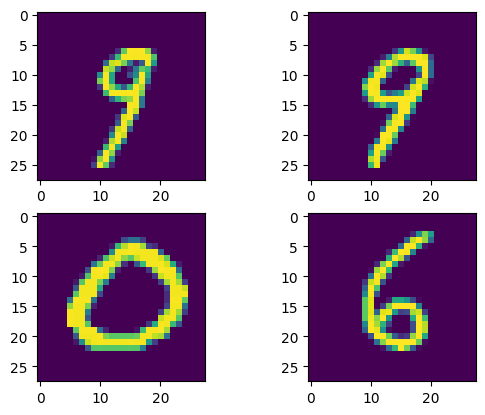

In [ ]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[43][:,:,0])
plt.subplot(222)
plt.imshow(x_train[423][:,:,0])
plt.subplot(223)
plt.imshow(x_train[435][:,:,0])
plt.subplot(224)
plt.imshow(x_train[9438][:,:,0])

In [ ]:
latent_dim = 2 # dimesion of sample z

In [ ]:
input_img = Input(shape=input_shape, name='encode_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #shape of conv to be provided to decoder
conv_shape

(None, 14, 14, 64)

In [ ]:
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [ ]:
z_mean = Dense(latent_dim, name='latent_mean')(x)
z_log_var = Dense(latent_dim, name='latent_log_var')(x)

###Reparameterization trick

$z = \mu + \sigma \odot \epsilon$ with $\epsilon \sim N(0,1)$

In [ ]:
def sample_z(args):
  z_mean, z_log_var = args
  eps = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]))
  return z_mean + K.exp(z_log_var * 0.5) * eps

###Next

In [ ]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

In [ ]:
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encode_input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encode_input[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

In [ ]:
#upscale image
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_ouput')(x)

In [ ]:
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_ouput (Conv2DTransp  (None, 28, 28, 1)        289       
 ose)                                                            
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [ ]:
class VAE(keras.Model):
  def __init__(self, **kwargs):
    super(VAE, self).__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder

    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="KL_loss")
    self.recons_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
  
  def call(self, inputs):
    x = inputs
    _, _, z = self.encoder(x)
    return self.decoder(z)
  
  def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
    z_mean, z_log_var, z = self.encoder(x)
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

    x_flatten = K.flatten(x)
    z_decoded = K.flatten(self.decoder(z))
    recons_loss = tf.keras.metrics.binary_crossentropy(x_flatten, z_decoded)
    total_loss = kl_loss + recons_loss

    return total_loss, kl_loss, recons_loss

  def train_step(self, data):
    x = data
    with tf.GradientTape() as tape:
      total_loss, kl_loss, recons_loss = self.compute_loss(x)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(total_loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    
    self.total_loss_tracker.update_state(total_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.recons_loss_tracker.update_state(recons_loss)

    return {"total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recons_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),}

  @property
  def metrics(self):
    return [self.total_loss_tracker,
            self.recons_loss_tracker,
            self.kl_loss_tracker,]


In [ ]:
vae_model = VAE()

In [ ]:
vae_model.compile(optimizer='adam')

In [ ]:
hist = vae_model.fit(x_train, None,
                     batch_size=128,
                     epochs=3)

Epoch 1/3
469/469 [==============================] - 33s 12ms/step - total_loss: 0.2903 - reconstruction_loss: 0.2902 - kl_loss: 3.4566e-04
Epoch 2/3
469/469 [==============================] - 6s 12ms/step - total_loss: 0.2635 - reconstruction_loss: 0.2635 - kl_loss: 4.6319e-08
Epoch 3/3
469/469 [==============================] - 6s 12ms/step - total_loss: 0.2632 - reconstruction_loss: 0.2632 - kl_loss: 4.1458e-08


In [ ]:
mu, _, _ = vae_model.encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 17ms/step


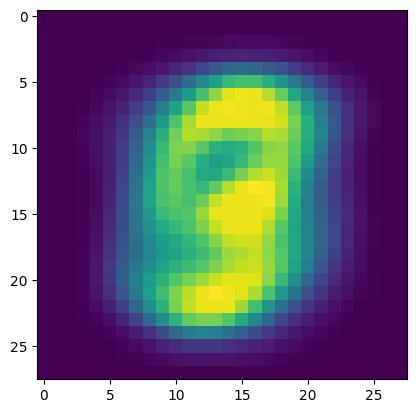

In [ ]:
sample_vector = np.array([[0, 0.5]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)